In [36]:
import torch
import torch.nn.functional as F
from task.TaskGenerator import SinTaskGenerator
import matplotlib.pyplot as plt

In [112]:
class OffsetVAE(torch.nn.Module):
    def __init__(self):
        super(OffsetVAE, self).__init__()
        self.enc1 = torch.nn.Linear(3, 16) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=16, hidden_size=16, num_layers=2, batch_first=True)
        self.enc31 = torch.nn.Linear(16, 8)
        self.enc32 = torch.nn.Linear(16, 8)
        
        self.dec1 = torch.nn.Linear(8 + 2, 512) # latent space, x, f_(t-1)(x)
        self.dec2 = torch.nn.Linear(512, 256)
        self.dec3 = torch.nn.Linear(256, 64)
        self.dec4 = torch.nn.Linear(64, 1)
    
    def encode(self, context):
        seq_len = context.shape[0]
        t = F.relu(self.enc1(context)).view(1, seq_len, 16)
        t = self.enc2(t)[0][0][-1, :] # we are interested only in the last output of the sequence
        t = F.relu(t)
        return self.enc31(t), self.enc32(t)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec1(z))
        h = F.relu(self.dec2(h))
        h = F.relu(self.dec3(h))
        return self.dec4(h)
    
    def forward(self, x, context):
        mu, logvar = self.encode(context)
        z = self.reparameterize(mu, logvar)
        
        if len(x.shape) > 1:
            z = z.repeat(x.shape[0], 1)
            z = torch.cat([z, x[:, 0:2]], dim=1)
        else:
            z = torch.cat([z, x[0:2]])    
        return self.decode(z), mu, logvar

In [113]:
model = OffsetVAE()
optimizer = torch.optim.Adam(model.parameters())

In [114]:
def elbo_loss(recon_f, f, mu, logvar):
    MSE = F.mse_loss(recon_f, f)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD

In [118]:
task_gen = SinTaskGenerator(x_min=-5, x_max=5)
dataset = []

max_a = 0.5
min_a = 10

min_phase = -1
max_phase = 1

min_freq = 2
max_freq = 2.1

offset_a_max = 2
offset_phase_max = 2
offset_f_max = 2

def sample_pair_tasks(n_batches=10, test_perc=0, batch_size=128):
    a_t1 = (min_a - max_a) * torch.rand(1) + max_a
    phase_t1 = (min_phase - max_phase) * torch.rand(1) + max_phase
    f_t1 = (min_freq - max_freq) * torch.rand(1) + max_freq
    
    a_t2 = a_t1 + torch.rand(1) * offset_a_max
    phase_t2 = phase_t1 + torch.rand(1) * offset_phase_max
    f_t2 = f_t1 + torch.rand(1) * offset_f_max
    
    data_loader = task_gen.get_pair_tasks(amplitude=(a_t1, a_t2), 
                                       phase=(phase_t1, phase_t2), 
                                       frequency=(f_t1, f_t2), 
                                       num_batches=n_batches,
                                       test_perc=test_perc,
                                       batch_size=128)
    return data_loader, a_t1, a_t2, phase_t1, phase_t2, f_t1, f_t2

# Dataset creation
n_tasks = 1000

data_set = []
a_set = []
phase_set = []
f_set = []
for _ in range(n_tasks):
    data, a_1, a_2, p_1, p_2, f_1, f_2 = sample_pair_tasks(n_batches=1, test_perc=0, batch_size=128)
    data_set.append(data)
    a_set.append((a_1, a_2))
    phase_set.append((p_1, p_2))
    f_set.append((f_1, f_2))

train_data = data_set[0:800]
valid_data = data_set[800:]

In [119]:
n_train_tasks = 800
n_valid_tasks = 200

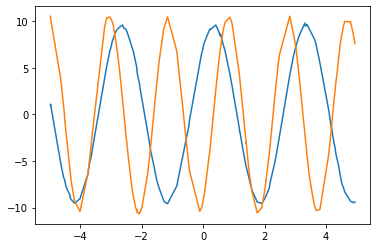

In [120]:
# Task visualization
idxes = [6]
for i in idxes:
    data = data_set[i][0]
    data = data['train']
    x = data[0]
    y1 = data[1]
    y2 = data[2]
    
    idx = x.squeeze(1).sort().indices
    plt.plot(x[idx],y1[idx])
    plt.plot(x[idx],y2[idx])

In [121]:
def train_offset_vae(n_iter=1):
    model.train()
    train_loss = 0
    task_idx = torch.randint(low=0, high=n_train_tasks, size=(1,)).item()
    data_loader = train_data[task_idx]
    
    for _ in range(n_iter):
        for batch_idx, batch in enumerate(data_loader):
            num_data_context = torch.randint(low=10, high=30, size=(1,)).item()
            batch = batch['train']
            idx = torch.randint(0, 128, (128,))
            ctx_idx = idx[0:num_data_context]
            x_idx = idx[num_data_context:]

            f = batch[2][x_idx]
            batch = torch.cat([batch[0], batch[1], batch[2]], dim=1)
            x = batch[x_idx]
            context = batch[ctx_idx]

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x=x, context=context)
            loss = elbo_loss(recon_batch, f, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    
    return train_loss / (n_iter*(batch_idx+1))

In [122]:
len(losses)

62593

In [123]:
n_epochs = 300000
losses = []
l_sum = 0
for i in range(n_epochs):
    l = train_offset_vae()
    l_sum += l
    losses.append(l)
    if i % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(i, l_sum/(i+1)))

====> Epoch: 0 Average loss: 24.8480
====> Epoch: 100 Average loss: 23.7970
====> Epoch: 200 Average loss: 23.0954
====> Epoch: 300 Average loss: 23.5125
====> Epoch: 400 Average loss: 23.2763
====> Epoch: 500 Average loss: 22.9634
====> Epoch: 600 Average loss: 22.8754
====> Epoch: 700 Average loss: 22.8898
====> Epoch: 800 Average loss: 22.8119
====> Epoch: 900 Average loss: 22.4774
====> Epoch: 1000 Average loss: 22.5391
====> Epoch: 1100 Average loss: 22.2720
====> Epoch: 1200 Average loss: 22.1787
====> Epoch: 1300 Average loss: 22.1416
====> Epoch: 1400 Average loss: 22.0240
====> Epoch: 1500 Average loss: 21.9137
====> Epoch: 1600 Average loss: 21.9141
====> Epoch: 1700 Average loss: 21.8345
====> Epoch: 1800 Average loss: 21.8175
====> Epoch: 1900 Average loss: 21.7943
====> Epoch: 2000 Average loss: 21.6338
====> Epoch: 2100 Average loss: 21.6040
====> Epoch: 2200 Average loss: 21.5814
====> Epoch: 2300 Average loss: 21.3883
====> Epoch: 2400 Average loss: 21.3254
====> Epoch:

====> Epoch: 20300 Average loss: 20.0859
====> Epoch: 20400 Average loss: 20.0889
====> Epoch: 20500 Average loss: 20.0847
====> Epoch: 20600 Average loss: 20.0865
====> Epoch: 20700 Average loss: 20.0850
====> Epoch: 20800 Average loss: 20.0738
====> Epoch: 20900 Average loss: 20.0737
====> Epoch: 21000 Average loss: 20.0671
====> Epoch: 21100 Average loss: 20.0630
====> Epoch: 21200 Average loss: 20.0501
====> Epoch: 21300 Average loss: 20.0418
====> Epoch: 21400 Average loss: 20.0280
====> Epoch: 21500 Average loss: 20.0081
====> Epoch: 21600 Average loss: 19.9918
====> Epoch: 21700 Average loss: 19.9825
====> Epoch: 21800 Average loss: 19.9813
====> Epoch: 21900 Average loss: 19.9672
====> Epoch: 22000 Average loss: 19.9613
====> Epoch: 22100 Average loss: 19.9623
====> Epoch: 22200 Average loss: 19.9524
====> Epoch: 22300 Average loss: 19.9409
====> Epoch: 22400 Average loss: 19.9389
====> Epoch: 22500 Average loss: 19.9355
====> Epoch: 22600 Average loss: 19.9347
====> Epoch: 227

====> Epoch: 40300 Average loss: 19.1108
====> Epoch: 40400 Average loss: 19.1056
====> Epoch: 40500 Average loss: 19.1022
====> Epoch: 40600 Average loss: 19.0980
====> Epoch: 40700 Average loss: 19.0903
====> Epoch: 40800 Average loss: 19.0877
====> Epoch: 40900 Average loss: 19.0826
====> Epoch: 41000 Average loss: 19.0751
====> Epoch: 41100 Average loss: 19.0674
====> Epoch: 41200 Average loss: 19.0649
====> Epoch: 41300 Average loss: 19.0629
====> Epoch: 41400 Average loss: 19.0557
====> Epoch: 41500 Average loss: 19.0568
====> Epoch: 41600 Average loss: 19.0556
====> Epoch: 41700 Average loss: 19.0487
====> Epoch: 41800 Average loss: 19.0440
====> Epoch: 41900 Average loss: 19.0416
====> Epoch: 42000 Average loss: 19.0431
====> Epoch: 42100 Average loss: 19.0463
====> Epoch: 42200 Average loss: 19.0411
====> Epoch: 42300 Average loss: 19.0363
====> Epoch: 42400 Average loss: 19.0299
====> Epoch: 42500 Average loss: 19.0215
====> Epoch: 42600 Average loss: 19.0143
====> Epoch: 427

====> Epoch: 60300 Average loss: 18.4403
====> Epoch: 60400 Average loss: 18.4372
====> Epoch: 60500 Average loss: 18.4390
====> Epoch: 60600 Average loss: 18.4352
====> Epoch: 60700 Average loss: 18.4283
====> Epoch: 60800 Average loss: 18.4306
====> Epoch: 60900 Average loss: 18.4271
====> Epoch: 61000 Average loss: 18.4235
====> Epoch: 61100 Average loss: 18.4191
====> Epoch: 61200 Average loss: 18.4151
====> Epoch: 61300 Average loss: 18.4133
====> Epoch: 61400 Average loss: 18.4119
====> Epoch: 61500 Average loss: 18.4138
====> Epoch: 61600 Average loss: 18.4109
====> Epoch: 61700 Average loss: 18.4070
====> Epoch: 61800 Average loss: 18.4060
====> Epoch: 61900 Average loss: 18.4038
====> Epoch: 62000 Average loss: 18.3962
====> Epoch: 62100 Average loss: 18.3905
====> Epoch: 62200 Average loss: 18.3850
====> Epoch: 62300 Average loss: 18.3816
====> Epoch: 62400 Average loss: 18.3786
====> Epoch: 62500 Average loss: 18.3742
====> Epoch: 62600 Average loss: 18.3744
====> Epoch: 627

KeyboardInterrupt: 

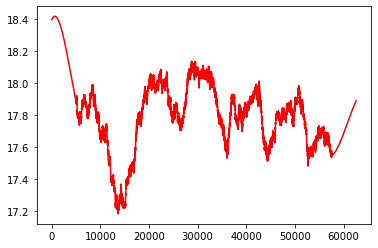

In [110]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,10001, 3) 

plt.plot(x, yhat, color='red')
plt.show()

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,10501, 3) 

plt.plot(x, yhat, color='red')
plt.show()